<a href="https://colab.research.google.com/github/clemencia/ML4PPGF_UERJ/blob/master/Exemplos_RNN_LSTM/LSTM_Keras_english2spanish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LSTM For English to Spanish translation

### Fonte :   Thomas Tracey
https://towardsdatascience.com/language-translation-with-rnns-d84d43b40571

https://github.com/tommytracey/AIND-Capstone/blob/master/README.md


In [0]:
# Start by importing all the things we'll need.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, CuDNNLSTM, Flatten, TimeDistributed, Dropout, LSTMCell, RNN
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.utils import tf_utils
from tensorflow.keras import backend as K

# This enables the Jupyter backend on some matplotlib installations.
%matplotlib notebook
import matplotlib.pyplot as plt
# Turn off interactive plots. iplt doesn't work well with Jupyter.
#plt.ioff()

%matplotlib inline


import unicodedata
import re
import numpy as np
import os
import time
import shutil

## Pulling and Pre-processing the Data
The first part of this notebook is pretty much a copy and paste from the aforementioned Tensorflow tutorial: we are using the exact same data as they do.

The only difference is that I've changed the code to translate from English to Spanish, not the other way around. I speak English natively and speak a little Spanish - so this feels more appropriate to me.

In [0]:
class LanguageIndex():
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(' '))
        self.vocab = sorted(self.vocab)
        self.word2idx["<pad>"] = 0
        self.idx2word[0] = "<pad>"
        for i,word in enumerate(self.vocab):
            self.word2idx[word] = i + 1
            self.idx2word[i+1] = word

# Download the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://download.tensorflow.org/data/spa-eng.zip', 
    extract=True)
path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.rstrip().strip()
    w = "<start> " + w + " <end>"
    return w

def max_length(t):
    return max(len(i) for i in t)

def create_dataset(path, num_examples):
    lines = open(path, encoding="UTF-8").read().strip().split("\n")
    word_pairs = [[preprocess_sentence(w) for w in l.split("\t")] for l in lines[:num_examples]]
    return word_pairs

def load_dataset(path, num_examples):
    pairs = create_dataset(path, num_examples)
    out_lang = LanguageIndex(sp for en, sp in pairs)
    in_lang = LanguageIndex(en for en, sp in pairs)
    input_data = [[in_lang.word2idx[s] for s in en.split(' ')] for en, sp in pairs]
    output_data = [[out_lang.word2idx[s] for s in sp.split(' ')] for en, sp in pairs]

    max_length_in, max_length_out = max_length(input_data), max_length(output_data)
    input_data = tf.keras.preprocessing.sequence.pad_sequences(input_data, maxlen=max_length_in, padding="post")
    output_data = tf.keras.preprocessing.sequence.pad_sequences(output_data, maxlen=max_length_out, padding="post")
    return input_data, output_data, in_lang, out_lang, max_length_in, max_length_out

One difference with our implementation is that we will need to provide two tensors for the target language. One is the "teacher tensor", which forces the decoder to follow a correct output stream. The other is the true "target tensor", which defines what the decoder should output given the teacher tensor. 

The only difference between the two is that the target tensor is just the teacher tensor shifted left by one word (and missing the "<START>" word).
    
To allow these two tensors to work in tandem, we will create two separate numpy arrays, even though the data is pretty much identical.

In [0]:
#num_examples = 118000 # Full example set.
num_examples = 50000 # Partial set for faster training
input_data, teacher_data, input_lang, target_lang, len_input, len_target = load_dataset(path_to_file, num_examples)


target_data = [[teacher_data[n][i+1] for i in range(len(teacher_data[n])-1)] for n in range(len(teacher_data))]
target_data = tf.keras.preprocessing.sequence.pad_sequences(target_data, maxlen=len_target, padding="post")
target_data = target_data.reshape((target_data.shape[0], target_data.shape[1], 1))

# Shuffle all of the data in unison. This training set has the longest (e.g. most complicated) data at the end,
# so a simple Keras validation split will be problematic if not shuffled.
p = np.random.permutation(len(input_data))
input_data = input_data[p]
teacher_data = teacher_data[p]
target_data = target_data[p]

BUFFER_SIZE = len(input_data)
BATCH_SIZE = 128
embedding_dim = 256
units = 1024
vocab_in_size = len(input_lang.word2idx)
vocab_out_size = len(target_lang.word2idx)

## Creating the Seq2Seq Model
Now, let's create a Keras model which will be used to implement the encoder and decoder. This will be done with the Keras Functional API.

There are two major components: the encoder and the decoder. We create this first model to train both concurrently by hooking them together. Later on we will use the trained weights from this model to create two separate models for inference.

Note that the Tensorflow tutorial uses a GRU while I will be using an LSTM. There isn't a huge difference between the two, other than that I believe the LSTM does a better job at this task.

In [0]:
# Create the Encoder layers first.
encoder_inputs = Input(shape=(len_input,))
encoder_emb = Embedding(input_dim=vocab_in_size, output_dim=embedding_dim)
encoder_lstm = CuDNNLSTM(units=units, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_emb(encoder_inputs))
encoder_states = [state_h, state_c]

# Now create the Decoder layers.
decoder_inputs = Input(shape=(None,))
decoder_emb = Embedding(input_dim=vocab_out_size, output_dim=embedding_dim)
decoder_lstm = CuDNNLSTM(units=units, return_sequences=True, return_state=True)
decoder_lstm_out, _, _ = decoder_lstm(decoder_emb(decoder_inputs), initial_state=encoder_states)
# Two dense layers added to this model to improve inference capabilities.
decoder_d1 = Dense(units, activation="relu")
decoder_d2 = Dense(vocab_out_size, activation="softmax")
# Drop-out is added in the dense layers to help mitigate overfitting in this part of the model. Astute developers
# may want to add the same mechanism inside the LSTMs.
decoder_out = decoder_d2(Dropout(rate=.4)(decoder_d1(Dropout(rate=.4)(decoder_lstm_out))))

# Finally, create a training model which combines the encoder and the decoder.
# Note that this model has three inputs:
#  encoder_inputs=[batch,encoded_words] from input language (English)
#  decoder_inputs=[batch,encoded_words] from output language (Spanish). This is the "teacher tensor".
#  decoder_out=[batch,encoded_words] from output language (Spanish). This is the "target tensor".
model = Model([encoder_inputs, decoder_inputs], decoder_out)
# We'll use sparse_categorical_crossentropy so we don't have to expand decoder_out into a massive one-hot array.
#  Adam is used because it's, well, the best.
model.compile(optimizer=tf.train.AdamOptimizer(), loss="sparse_categorical_crossentropy", metrics=['sparse_categorical_accuracy'])

The next cell trains the model and plots the training and verification losses. It will take a **long** time, especially if you use the full data set. If you run into memory errors, reduce the data set size (less words in the language), the batch size, or the dimensionality of the model.

When training this model, I saw modest improvements all the way up to Epoch 30 when using the full dataset. This took around 2 hours on an RTX 2080Ti. I'd recommend using a smaller dataset and less Epoch's if you are just playing around.

In [26]:
# Note, we use 20% of our data for validation.
epochs = 15
history = model.fit([input_data, teacher_data], target_data,
                 batch_size=BATCH_SIZE,
                 epochs=epochs,
                 validation_split=0.2)



Train on 40000 samples, validate on 10000 samples
Epoch 1/15
40000/40000 [==============================] - 50s 1ms/sample - loss: 1.9417 - sparse_categorical_accuracy: 0.7208 - val_loss: 1.5930 - val_sparse_categorical_accuracy: 0.7631
Epoch 2/15
40000/40000 [==============================] - 48s 1ms/sample - loss: 1.4711 - sparse_categorical_accuracy: 0.7757 - val_loss: 1.3799 - val_sparse_categorical_accuracy: 0.7888
Epoch 3/15
40000/40000 [==============================] - 48s 1ms/sample - loss: 1.2693 - sparse_categorical_accuracy: 0.7965 - val_loss: 1.2375 - val_sparse_categorical_accuracy: 0.8051
Epoch 4/15
40000/40000 [==============================] - 48s 1ms/sample - loss: 1.1117 - sparse_categorical_accuracy: 0.8125 - val_loss: 1.1164 - val_sparse_categorical_accuracy: 0.8207
Epoch 5/15
40000/40000 [==============================] - 48s 1ms/sample - loss: 0.9772 - sparse_categorical_accuracy: 0.8262 - val_loss: 1.0313 - val_sparse_categorical_accuracy: 0.8322
Epoch 6/15
4000

With the full dataset, you should get an accuracy of up to 95% on the training data with a validation accuracy just below 89%. The validation accuracy starts to plateau around epoch 15, suggesting this model isn't really inferring anymore and is just overfitting.


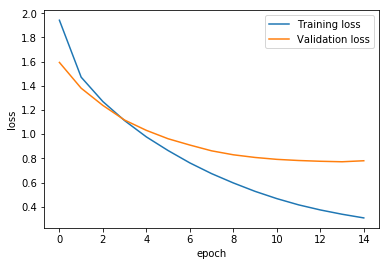

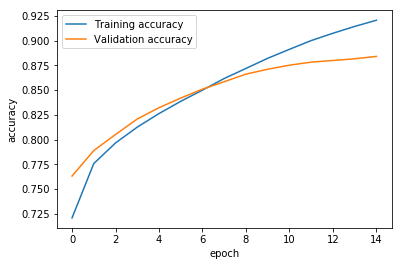

In [51]:
# Plot the results of the training.

plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
#print(history.history["loss"],history.epoch)
plt.legend(loc="upper right")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

plt.plot(history.history["sparse_categorical_accuracy"],label="Training accuracy")
plt.plot(history.history["val_sparse_categorical_accuracy"],label="Validation accuracy")
plt.legend(loc="upper left")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

## Inference
The trick to our Keras seq2seq model is that Inference will require two separate models from training. This is because during training, we used a "teacher tensor" to force the model to continuously make predictions assuming it had gotten everything before right. Now we want it to make those predictions all by itself.

To accomplish this, we need to break up the encoder and decoder mechanisms. We will then run the entire input sequence through the encoder, then form the output by executing the decoder one step at a time.

In [0]:
# Create the encoder model from the tensors we previously declared.
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])

# Generate a new set of tensors for our new inference decoder. Note that we are using new tensors, 
# this does not preclude using the same underlying layers that we trained on. (e.g. weights/biases).
inf_decoder_inputs = Input(shape=(None,), name="inf_decoder_inputs")
# We'll need to force feed the two state variables into the decoder each step.
state_input_h = Input(shape=(units,), name="state_input_h")
state_input_c = Input(shape=(units,), name="state_input_c")
decoder_res, decoder_h, decoder_c = decoder_lstm(
    decoder_emb(inf_decoder_inputs), 
    initial_state=[state_input_h, state_input_c])
inf_decoder_out = decoder_d2(decoder_d1(decoder_res))
inf_model = Model(inputs=[inf_decoder_inputs, state_input_h, state_input_c], 
                  outputs=[inf_decoder_out, decoder_h, decoder_c])

Now that we've got our models, let's define some functions that will assist us in actually translating a given string of text.

In [0]:
# Converts the given sentence (just a string) into a vector of word IDs
# using the language specified. This can be used for either the input (English)
# or target (Spanish) languages.
# Output is 1-D: [timesteps/words]
def sentence_to_vector(sentence, lang):
    pre = preprocess_sentence(sentence)
    vec = np.zeros(len_input)
    sentence_list = [lang.word2idx[s] for s in pre.split(' ')]
    for i,w in enumerate(sentence_list):
        vec[i] = w
    return vec

# Given an input string, an encoder model (infenc_model) and a decoder model (infmodel),
# return a translated string.
def translate(input_sentence, infenc_model, infmodel, attention=False):
    sv = sentence_to_vector(input_sentence, input_lang)
    # Reshape so we can use the encoder model. New shape=[samples,sequence length]
    sv = sv.reshape(1,len(sv))
    [emb_out, sh, sc] = infenc_model.predict(x=sv)
    
    i = 0
    start_vec = target_lang.word2idx["<start>"]
    stop_vec = target_lang.word2idx["<end>"]
    # We will continuously feed cur_vec as an input into the decoder to produce the next word,
    # which will be assigned to cur_vec. Start it with "<start>".
    cur_vec = np.zeros((1,1))
    cur_vec[0,0] = start_vec
    cur_word = "<start>"
    output_sentence = ""
    # Start doing the feeding. Terminate when the model predicts an "<end>" or we reach the end
    # of the max target language sentence length.
    while cur_word != "<end>" and i < (len_target-1):
        i += 1
        if cur_word != "<start>":
            output_sentence = output_sentence + " " + cur_word
        x_in = [cur_vec, sh, sc]
        # This will allow us to accomodate attention models, which we will talk about later.
        if attention:
            x_in += [emb_out]
        [nvec, sh, sc] = infmodel.predict(x=x_in)
        # The output of the model is a massive softmax vector with one spot for every possible word. Convert
        # it to a word ID using argmax().
        cur_vec[0,0] = np.argmax(nvec[0,0])
        cur_word = target_lang.idx2word[np.argmax(nvec[0,0])]
    return output_sentence
    

In [58]:
# Let's test out the model! Feel free to modify as you see fit. Note that only words
# that we've trained the model on will be available, otherwise you'll get an error.
print(translate("I like you", encoder_model, inf_model))
print(translate("I'm so hungry", encoder_model, inf_model))
print(translate("I don't have a clue", encoder_model, inf_model))

 me agradas .
 estoy tan hambriento .
 no tengo idea .
